## Exercise 2.2 PCA for visualization purposes (3 points)

In this exercise you will perform visualization of [MNIST](http://yann.lecun.com/exdb/mnist/) dataset using PCA. The end result of this exercise should look like [Embedding Projector](https://projector.tensorflow.org/) (please select "Mnist with images" in the dropdown menu on the left of the page).  
Write your code in the respective cells. Of course, you can add additional cells or change their order, but please don't significantly change the structure of the notebook. You must use PyTorch tensors to perform all the calculations.  
For each question that requires written answer, please write it in a markdown cell.

In [12]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


#### Loading the data

In [13]:
# Download the dataset and save it to a local folder. You should use the train set.
mnist_dataset = torchvision.datasets.MNIST('data/', train=True, download=True)

X, Y = mnist_dataset.data, mnist_dataset.targets
print(X.shape)

X_flat = X.reshape(-1, 28*28).float()
print(X_flat.shape)

# We must make the data zero-centered before applying PCA
M = torch.mean(X_flat)
X_flat = X_flat - M

torch.Size([60000, 28, 28])
torch.Size([60000, 784])


### 2.2.1. Perform PCA on the input data (1 point)

Calculate covariance matrix of the input data. Hint: You can use torch.matmul for matrix multiplication.

In [14]:
cov_mat = torch.matmul(X_flat.T, X_flat)
print(cov_mat.shape)

torch.Size([784, 784])


Perform eigendecomposion of the covariance matrix. Hint: you can use torch.linalg.eig.

In [15]:
eigen_val, eigen_vec = torch.linalg.eigh(cov_mat)
#eigen_val = eigen_val.real
print(eigen_val[0:10])
print(eigen_val[774:])

tensor([-3379.9036, -1529.5582,  -935.9312,  -833.6968,  -762.7579,  -665.4233,
         -477.9605,  -439.9357,  -433.8494,  -367.5314])
tensor([4.8770e+09, 5.8597e+09, 5.9805e+09, 7.4940e+09, 8.8710e+09, 1.0840e+10,
        1.2602e+10, 1.4596e+10, 1.8775e+10, 9.2263e+10])


### 2.2.2 Analyzing the results of PCA (1 point)

Extract the first two principal components of the data, i.e. reduce the dimensionality of the dataset to 2. Plot the result. Different numbers must be represented as different colors on the scatter plot. You can use a randomly sampled portion of the data so that the plot doesn't get cluttered.   
Describe whether it's possible to differentiate the numbers in 2 dimensions. Are there any additional observations?

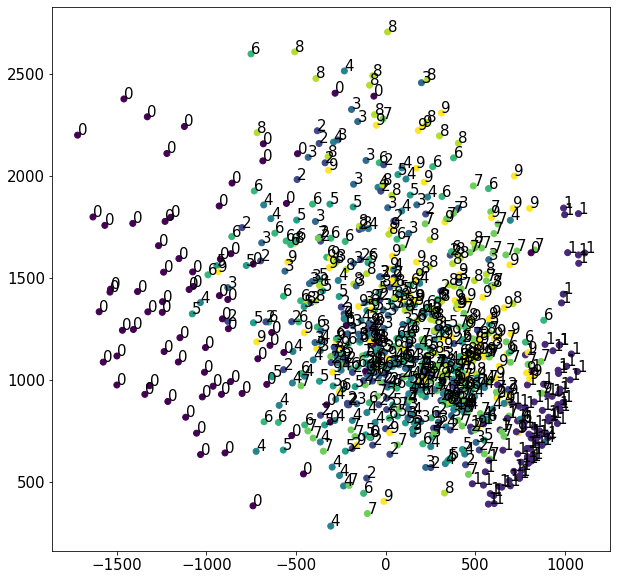

In [16]:
# sample_size = ...
from matplotlib.pyplot import figure


extracted_eigen_vec = eigen_vec[:,782:]
pca_data = torch.matmul(X_flat, extracted_eigen_vec)

plt.rc('figure', figsize=(10, 10))
plt.rcParams.update({'font.size': 15})
_,pl = plt.subplots()
a = pca_data[1000:1800,0]
b = pca_data[1000:1800,1]
t = Y[1000:1800]

pl.scatter(a, b, c= t)

for i, z in enumerate(t):
    pl.annotate(z.numpy(),(a[i],b[i]))
plt.show()

Observations:
It is difficult to differentiate the numbers in 2 dimensions. The number 1's are mostly clustered but others are more or less scatterd in 2d space. Also some of the numbers such as 0's are scattered somewhat as outliers. The reason is they are written very differently from most of the images of their class.  


Plot the graph of cumulative explained variance vs number of components. You might also want to make an additional plot for the first N components. How many components should we use to describe the data? Motivate your answer.

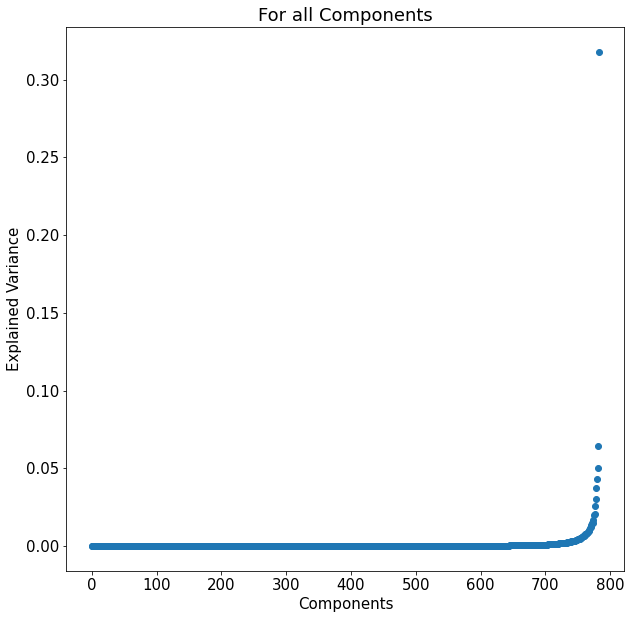

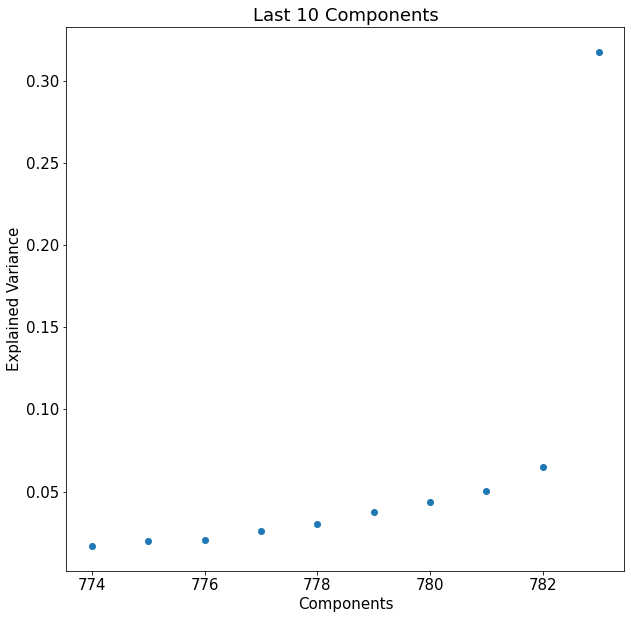

Variance of last 10 components
0.62732625


In [17]:
sum = torch.sum(eigen_val)
explained_var = torch.div( eigen_val,sum)
variance_list = explained_var.numpy()
components = list(range(0,784))
plt.scatter(components, variance_list)
plt.xlabel('Components')
plt.ylabel('Explained Variance')
plt.title("For all Components")
plt.show()

plt.scatter(components[774:], variance_list[774:])
plt.xlabel('Components')
plt.ylabel('Explained Variance')
plt.title("Last 10 Components")
plt.show()

print("Variance of last 10 components")
print(torch.sum(explained_var[774:]).numpy())

 From the image we can see that the maximum variance is captured by the last 10 components(eigenvalues are sorted from lowest to highest).Choosing components for lower eigenvalues do not represent the data eifficiently. Thats is why I would choose the last 10 componets which will capture 62% variance of the data.  

### 2.2.3 Visualizing the data in 3 dimensions (1 point)

Reduce the dimensionality of the dataset to 3. Using Tensorboard visualize the resultant data in 3 dimensions. You should get the result similar to the [Embedding Projector](https://projector.tensorflow.org/) project (actually, they use the same Tensorboard package, so the result might be even exactly the same). You can use differently colored points instead of the digit pictures.

In [18]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/3d_visualization')

extracted_eigen_vec_3d = eigen_vec[:,781:]
pca_data = torch.matmul(X_flat, extracted_eigen_vec_3d)
pca_data = torch.tensor(pca_data)
labels = torch.tensor(Y)

writer.add_embedding(pca_data,metadata = labels)
writer.close()

/var/folders/hm/xkjzyd4d26l9g8h9y20nxxsc0000gn/T/ipykernel_24659/3274698769.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pca_data = torch.tensor(pca_data)
/var/folders/hm/xkjzyd4d26l9g8h9y20nxxsc0000gn/T/ipykernel_24659/3274698769.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(Y)


Analyze the resultant plot.  
Is 3 dimensions considerably better than 2?  
Which digits stand out in 3D and which digits are difficult to differentiate in 3 dimensions?

## Exercise 2.3. PCA vs Linear Regression (2 points)

### 2.3.1. Generating data (0.5 point)

Generate 2 dimensional linear data that follows the model assumed by linear regression (i.e. $y = \textbf{x}^T\textbf{w} + \epsilon$). For the purpose of this exercise you can use the following model: $y = 2x + 20 + \epsilon$, where $\epsilon \sim \mathcal{N}(0, 50)$. Generate 100 datapoints with $x$ varying anywhere from 0 to 200.  
Plot the resultant data.

In [19]:
def data_generator(x): 
    n=np.random.normal(0,50,100)
    y = 2*x+20+ n
    y = np.reshape(y, (100,1))
    return y

x = np.random.randint(0,200,100)
y = data_generator(x)
x = np.reshape(x, (100,1))



### 2.3.2. Performing PCA and Linear Regression (1.5 points)

Fit Linear Regression model for this data. Hint: for this purpose you can use sklearn.linear_model.LinearRegression.

In [20]:
lr = LinearRegression()
lr_model = lr.fit(x,y)


Perform PCA on the generated data. This time you can use ready-to-use methods from packages, e.g. from sklearn.

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
new_data = np.concatenate((x, y), axis=1)
sc = StandardScaler(with_std=False)
sc.fit(new_data)
new_data = sc.transform(new_data)
pca_model = PCA(n_components=2)
pca_model.fit(new_data)
print(pca_model.singular_values_)
print(pca_model.explained_variance_ratio_)

[1357.66130576  199.16727076]
[0.97893284 0.02106716]


Again plot the data, but this time include Linear Regression model line and the first principle component of PCA (plot it as a line of different color).

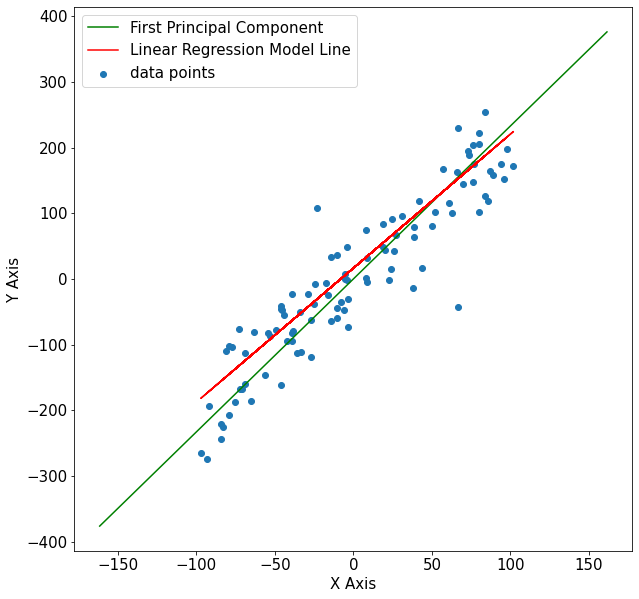

In [22]:
new_y = np.reshape(new_data[:,0],(100,1))

ev = 3 * np.sqrt(pca_model.explained_variance_[0]) 
ev_arr = np.array([[-ev, ev]])
evec = np.array([pca_model.components_[0]]).T
x_val,y_val = np.dot(evec, ev_arr)


plt.scatter(new_data[:,0],new_data[:,1], label= 'data points')
plt.plot(x_val,y_val, color='g', label= 'First Principal Component')
plt.plot(new_data[:,0],lr_model.predict(new_y), color='r', label= 'Linear Regression Model Line')
plt.legend(loc="upper left")
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()



Comment on the similarities and differences of two lines. What does PCA algorithm tries to minimize? What does Linear Regression algorithm tries to minimize? Write at least 4-5 sentences. Alternatively, provide graphical illustration on the same plot (in that case you can write less).

Observations:
There are hardly any similarities between first principal component and Linear Regression Model line. LR model
tries to predict the dependent variable based on independent variable by reducing the residuals whereas
the first principal component lies in the direction where data has highest variance. PC actually tries to capture the relation between all the features.